## importing the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from tqdm import tqdm

## Importing the dataset

In [2]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((100,100)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(),
])



In [3]:
data_dir = '/kaggle/input/satellite-image-classification/data'
data = datasets.ImageFolder(data_dir, transform=data_transform)

## Splitting data into train and test

In [4]:
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_set, test_set = torch.utils.data.random_split(data, [train_size, test_size])

In [5]:
batch_size = 33
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=batch_size) 
test_loader = torch.utils.data.DataLoader(test_set, shuffle=False, batch_size=batch_size)

## Creating the model

In [6]:
model = models.densenet121(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(
            nn.Linear(1024, 460),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(460,5)
)
for param in model.classifier.parameters():
    param.requires_grad = True
    
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 76.7MB/s]


In [7]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

## Deifing the Criterion and optimizer

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

## training the Model

In [9]:
Epochs = 10
train_losses = {}
train_accu = {}
test_losses = {}
test_accu = {}

for epoch in range(Epochs):
    train_loss = []
    test_loss = []
    train_acc = 0
    test_acc = 0
    
    # Training loop with progress bar
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{Epochs}")
    model.train()  # Ensure the model is in training mode
    
    for img, label in train_loader_tqdm:
        img, label = img.to(device), label.to(device)
        
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, label)
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
        # Predictions and accuracy calculation
        _, pred = torch.max(output, 1)
        train_acc += (pred == label).sum().item()  # Convert to item for compatibility
    
    # Compute average loss and accuracy for training
    train_losses[epoch] = np.mean(train_loss)
    train_accu[epoch] = 100 * train_acc / len(train_loader.dataset)  # Accuracy based on total dataset size
    
    # Update the progress bar with current train loss and accuracy
    train_loader_tqdm.set_postfix({
        'train loss': train_losses[epoch], 
        'train accuracy': train_accu[epoch]
    })
    
    # Testing loop with progress bar
    test_loader_tqdm = tqdm(test_loader, desc=f"Epoch {epoch+1}/{Epochs}")
    model.eval()  # Set the model to evaluation mode (no gradient calculation)
    
    with torch.no_grad():  # No gradients during testing
        for img, label in test_loader_tqdm:
            img, label = img.to(device), label.to(device)
            output = model(img)
            loss = criterion(output, label)
            test_loss.append(loss.item())
            
            # Predictions and accuracy calculation
            _, pred = torch.max(output, 1)
            test_acc += (pred == label).sum().item()  # Convert to item for compatibility
    
    # Compute average loss and accuracy for testing
    test_losses[epoch] = np.mean(test_loss)
    test_accu[epoch] = 100 * test_acc / len(test_loader.dataset)  # Accuracy based on total dataset size
    
    # Update the progress bar with current test loss and accuracy
    test_loader_tqdm.set_postfix({
        'test loss': test_losses[epoch], 
        'test accuracy': test_accu[epoch]  # Corrected to 'test accuracy'
    })
    print(f'Epoch{epoch+1}/{Epochs}, Train_loss: {train_losses[epoch]}, Train_acc: {train_accu[epoch]}, Test_loss: {test_losses[epoch]}, Test_acc: {test_accu[epoch]}')

Epoch 1/10: 100%|██████████| 35/35 [00:09<00:00,  3.79it/s]


Epoch1/10, Train_loss: 0.412915614046102, Train_acc: 87.96625222024866, Test_loss: 0.13475867531129293, Test_acc: 95.74090505767525


Epoch 2/10: 100%|██████████| 35/35 [00:03<00:00, 11.51it/s]


Epoch2/10, Train_loss: 0.14403682353015798, Train_acc: 95.5373001776199, Test_loss: 0.07662518482123103, Test_acc: 97.87045252883762


Epoch 3/10: 100%|██████████| 35/35 [00:02<00:00, 11.91it/s]


Epoch3/10, Train_loss: 0.10899190935068322, Train_acc: 96.51420959147424, Test_loss: 0.09253301965072751, Test_acc: 97.07187222715173


Epoch 4/10: 100%|██████████| 35/35 [00:02<00:00, 11.68it/s]


Epoch4/10, Train_loss: 0.0857874685150646, Train_acc: 97.06927175843694, Test_loss: 0.043729590398392505, Test_acc: 98.40283939662821


Epoch 5/10: 100%|██████████| 35/35 [00:03<00:00, 11.50it/s]


Epoch5/10, Train_loss: 0.07915299318146206, Train_acc: 97.35790408525754, Test_loss: 0.06419417607331915, Test_acc: 98.22537710736468


Epoch 6/10: 100%|██████████| 35/35 [00:02<00:00, 11.86it/s]


Epoch6/10, Train_loss: 0.07567461043507893, Train_acc: 97.44671403197158, Test_loss: 0.043877964799425434, Test_acc: 98.58030168589175


Epoch 7/10: 100%|██████████| 35/35 [00:02<00:00, 11.90it/s]


Epoch7/10, Train_loss: 0.06852440618617582, Train_acc: 97.53552397868562, Test_loss: 0.04380229733485196, Test_acc: 98.58030168589175


Epoch 8/10: 100%|██████████| 35/35 [00:02<00:00, 11.99it/s]


Epoch8/10, Train_loss: 0.06716126975786947, Train_acc: 97.82415630550622, Test_loss: 0.07602446741823639, Test_acc: 97.51552795031056


Epoch 9/10: 100%|██████████| 35/35 [00:02<00:00, 12.14it/s]


Epoch9/10, Train_loss: 0.0626729503817802, Train_acc: 97.46891651865009, Test_loss: 0.041035907698928245, Test_acc: 98.58030168589175


Epoch 10/10: 100%|██████████| 35/35 [00:02<00:00, 12.47it/s]

Epoch10/10, Train_loss: 0.05818637113603525, Train_acc: 98.0461811722913, Test_loss: 0.0422935734236879, Test_acc: 98.75776397515529


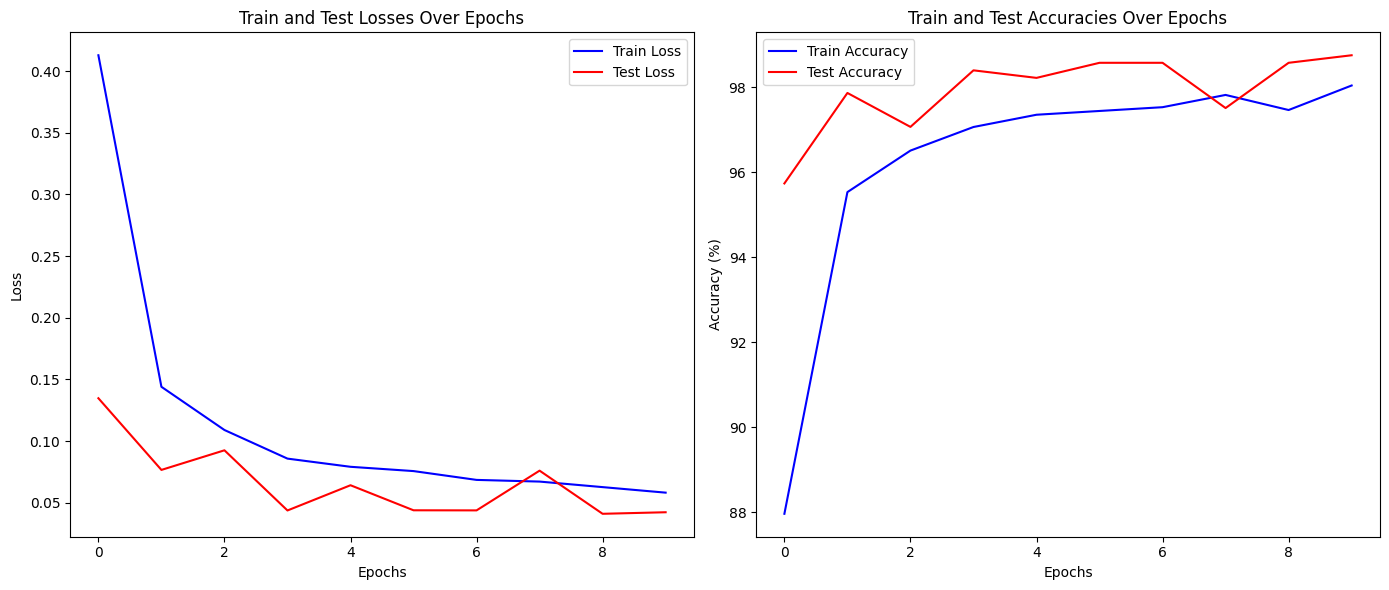

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plotting Losses (Left subplot)
ax1.plot(train_losses.values(), 'b', label='Train Loss')
ax1.plot(test_losses.values(), 'r', label='Test Loss')
ax1.set_title('Train and Test Losses Over Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plotting Accuracies (Right subplot)
ax2.plot(train_accu.values(), 'b', label='Train Accuracy')
ax2.plot(test_accu.values(), 'r', label='Test Accuracy')
ax2.set_title('Train and Test Accuracies Over Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()